<a href="https://colab.research.google.com/github/Krystian3000/nft_price_prediciton/blob/main/TFT_pytorch_implementation_vol1_1min_agg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [ ]:
!pip install pytorch_forecasting

In [ ]:
import numpy as np
import pandas as pd
import wandb
from google.colab import userdata
from google.cloud import bigquery
import os
from pathlib import Path
import requests
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

In [ ]:
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, RMSE, MAPE, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.encoders import TorchNormalizer, GroupNormalizer
from pytorch_lightning.loggers import WandbLogger
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

# Load the data

In [ ]:
response = requests.get(f"https://raw.githubusercontent.com/Krystian3000/frontend/main/panelApps/nft-engineering-diploma-c933de618c2e.json?token=GHSAT0AAAAAACEDDV2HACZPSSQJIRAGWKXEZKKS3LQ", headers = {'Authorization': f'token {userdata.get("github_token")}'})

if response.status_code == 200:
    # If the request is successful, save the file locally
    with open("bigquery_secret.json", 'wb') as file:
        file.write(response.content)
    print("Successfully saved file")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


Successfully saved file


In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(Path(os.getcwd()).resolve(), "bigquery_secret.json")

In [ ]:
wandb.login(key=userdata.get("wandb_api_key"))

wandb: Currently logged in as: krystian-opala. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb_logger = WandbLogger(
    log_model='all', #checkpoints logged during training
    project='tft_v1'
)

In [ ]:
def execute_query(query):
    # Create a BigQuery client
    client = bigquery.Client()

    # Create a context manager to ensure the connection is properly closed
    with client as bq_client:
        # Run the query
        query_job = bq_client.query(query)
        # Wait for the query to complete
        df = query_job.to_dataframe()

    client.close()
    del client

    return df

In [ ]:
query = f"""SELECT DATETIME(date_time) as date_time,
           cnt_active_listings,
           active_floor_price,
           active_max_price,
           avg_active_price,
           active_listed_volume,
           cnt_new_auctions,
           FROM `nft-engineering-diploma.beanz.beanz_1m_aggregate_listings`"""
df_raw = execute_query(query)

In [ ]:
df_raw_types = df_raw.astype({"active_listed_volume":int, "active_floor_price":float, "avg_active_price":float, "avg_active_price":float, "active_max_price":float})

In [ ]:
df_raw_types.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847551 entries, 0 to 847550
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date_time             846961 non-null  datetime64[ns]
 1   cnt_active_listings   847551 non-null  Int64         
 2   active_floor_price    847551 non-null  float64       
 3   active_max_price      847551 non-null  float64       
 4   avg_active_price      847551 non-null  float64       
 5   active_listed_volume  847551 non-null  int64         
 6   cnt_new_auctions      847551 non-null  Int64         
dtypes: Int64(2), datetime64[ns](1), float64(3), int64(1)
memory usage: 46.9 MB


## Missing values in datetime column

Missing values in this context mean that no new listing has been created in given minute. To cope with this problem we'll substitute missing values with previous values, as to

In [ ]:
dt_left = pd.DataFrame(pd.date_range(*df_raw_types.date_time.agg(["min","max"]), freq='1min'), columns=['date_time'])
dt_left.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846374 entries, 0 to 846373
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date_time  846374 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 6.5 MB


In [ ]:
df_raw_ffill = dt_left.merge(df_raw_types, on='date_time',how='left').sort_values('date_time').fillna('ffill') #replace missing values with previous

In [ ]:
df = df_raw_ffill.rename(columns={'active_floor_price':'price'}).astype({"price":np.float16}).set_index('date_time').copy() #deepcopy to avoid inference
df

,cnt_active_listings,price,active_max_price,avg_active_price,active_listed_volume,cnt_new_auctions
date_time,,,,,,
2022-03-31 05:47:00,1,6.898438,6.9000,6.900000,6,1
2022-03-31 05:48:00,1,6.898438,6.9000,6.900000,6,0
2022-03-31 05:49:00,2,6.898438,6.9690,6.934500,13,1
2022-03-31 05:50:00,3,5.000000,6.9690,6.289667,18,1
2022-03-31 05:51:00,3,5.000000,6.9690,6.289667,18,0
...,...,...,...,...,...,...
2023-11-08 23:56:00,30,0.429932,2.7319,0.701436,21,0
2023-11-08 23:57:00,30,0.429932,2.7319,0.701436,21,0
2023-11-08 23:58:00,30,0.429932,2.7319,0.701436,21,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 846961 entries, 2022-03-31 05:47:00 to 2023-11-09 00:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cnt_active_listings   846961 non-null  Int64  
 1   price                 846961 non-null  float16
 2   active_max_price      846961 non-null  float64
 3   avg_active_price      846961 non-null  float64
 4   active_listed_volume  846961 non-null  int64  
 5   cnt_new_auctions      846961 non-null  Int64  
dtypes: Int64(2), float16(1), float64(2), int64(1)
memory usage: 42.0 MB


## Load static files

In [ ]:
from google.cloud import storage

def download_objects(bucket_name, local_directory):
    """Download all objects from a Google Cloud Storage bucket to a local directory."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blobs = bucket.list_blobs()

    for blob in blobs:
        destination_file_path = f"{local_directory}/{blob.name}"
        blob.download_to_filename(destination_file_path)
        print(f"Downloaded: {blob.name} to {destination_file_path}")

In [ ]:
download_objects('predictive_model_static', os.getcwd())

Downloaded: nft_worldwide_google_search.csv to /content/nft_worldwide_google_search.csv
Downloaded: s&p500-2018-2023.11.10.xls to /content/s&p500-2018-2023.11.10.xls


## Create additional datetime features + load static files

In [ ]:
def create_ts_features(df):
  df['datetime'] = df.index
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['Date'] = pd.to_datetime(df.index.date) #tmp

  #nft searches weekly - interest level
  df_nft_worldwide = (pd.read_csv("nft_worldwide_google_search.csv", skiprows=3, parse_dates=[0], infer_datetime_format='%Y-%m', names=['Year_month','google_searches_nft_scaled'])
                      .replace({"google_searches_nft_scaled":{"<1":"0"}})
                      .reset_index(drop=True)
                      .astype({'google_searches_nft_scaled':int})
                      .assign(google_searches_nft_scaled = lambda x:x['google_searches_nft_scaled'] / 100))
  # Expand the rows
  expanded_df = pd.DataFrame({
    'Date': df_nft_worldwide.apply(lambda row: pd.date_range(row['Year_month'], row['Year_month'] + pd.DateOffset(months=1, days=-1), freq='D'), axis=1).explode(),
    'google_searches_nft_scaled': df_nft_worldwide['google_searches_nft_scaled'].repeat(df_nft_worldwide['Year_month'].dt.days_in_month)
  }).reset_index(drop=True)

  df = df.merge(expanded_df, on='Date', how='left')

  #s&p500 - external market indice; quick look at the stock market and economy status
  df_sp500 = (pd.read_excel("s&p500-2018-2023.11.10.xls", skiprows=7, names=['datetime','sp500_value'], parse_dates=['datetime'])
              .dropna()
              .assign(datetime=lambda x: pd.to_datetime(x['datetime']))
              )

  expanded_df_sp500 = df_sp500.set_index('datetime').resample('1min').ffill()

  df = df.merge(expanded_df_sp500, on='datetime', how='left')
  df = df.drop(columns=['Date'])
  df = df.set_index('datetime')
  return df

In [ ]:
df_features = create_ts_features(df)

In [ ]:
df_features

,cnt_active_listings,price,active_max_price,avg_active_price,active_listed_volume,cnt_new_auctions,hour,dayofweek,quarter,month,year,dayofyear,google_searches_nft_scaled,sp500_value
datetime,,,,,,,,,,,,,,
2022-03-31 05:47:00,1,6.898438,6.9000,6.900000,6,1,5,3,1,3,2022,90,0.45,4530.41
2022-03-31 05:48:00,1,6.898438,6.9000,6.900000,6,0,5,3,1,3,2022,90,0.45,4530.41
2022-03-31 05:49:00,2,6.898438,6.9690,6.934500,13,1,5,3,1,3,2022,90,0.45,4530.41
2022-03-31 05:50:00,3,5.000000,6.9690,6.289667,18,1,5,3,1,3,2022,90,0.45,4530.41
2022-03-31 05:51:00,3,5.000000,6.9690,6.289667,18,0,5,3,1,3,2022,90,0.45,4530.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08 23:56:00,30,0.429932,2.7319,0.701436,21,0,23,2,4,11,2023,312,0.05,4382.78
2023-11-08 23:57:00,30,0.429932,2.7319,0.701436,21,0,23,2,4,11,2023,312,0.05,4382.78
2023-11-08 23:58:00,30,0.429932,2.7319,0.701436,21,0,23,2,4,11,2023,312,0.05,4382.78


# Simple EDA of dataset

In [ ]:
df_features.describe()

,cnt_active_listings,price,active_max_price,avg_active_price,active_listed_volume,cnt_new_auctions,hour,dayofweek,quarter,month,year,dayofyear,google_searches_nft_scaled,sp500_value
count,846961.0,846961.000000,846961.000000,846961.000000,846961.000000,846961.0,846961.000000,846961.000000,846961.000000,846961.000000,846961.000000,846961.000000,846961.000000,846961.000000
mean,703.739244,NaN,308.811627,5.581126,4802.393973,0.196089,11.495742,3.000000,2.604402,6.758351,2022.530831,189.867693,0.143207,4113.245387
std,480.809447,0.000000,320.218288,3.367992,6552.001517,1.070514,6.925306,2.000411,0.996842,3.025694,0.499049,92.406023,0.094896,242.359194
min,1.0,0.000100,2.000000,0.513401,6.000000,0.0,0.000000,0.000000,1.000000,1.000000,2022.000000,1.000000,0.050000,3577.030000
25%,343.0,0.449951,88.870000,3.951059,1595.000000,0.0,5.000000,1.000000,2.000000,4.000000,2022.000000,119.000000,0.080000,3932.690000
50%,625.0,0.899902,169.690000,5.299071,3392.000000,0.0,11.000000,3.000000,3.000000,7.000000,2023.000000,192.000000,0.110000,4109.310000
75%,908.0,1.370117,420.690000,6.281680,4733.000000,0.0,17.000000,5.000000,3.000000,9.000000,2023.000000,266.000000,0.160000,4308.500000
max,3246.0,6.898438,1992.000000,41.454233,54264.000000,200.0,23.000000,6.000000,4.000000,12.000000,2023.000000,365.000000,0.450000,4588.960000


In [ ]:
df_features

,cnt_active_listings,price,active_max_price,avg_active_price,active_listed_volume,cnt_new_auctions,hour,dayofweek,quarter,month,year,dayofyear,google_searches_nft_scaled,sp500_value
datetime,,,,,,,,,,,,,,
2022-03-31 05:47:00,1,6.898438,6.9000,6.900000,6,1,5,3,1,3,2022,90,0.45,4530.41
2022-03-31 05:48:00,1,6.898438,6.9000,6.900000,6,0,5,3,1,3,2022,90,0.45,4530.41
2022-03-31 05:49:00,2,6.898438,6.9690,6.934500,13,1,5,3,1,3,2022,90,0.45,4530.41
2022-03-31 05:50:00,3,5.000000,6.9690,6.289667,18,1,5,3,1,3,2022,90,0.45,4530.41
2022-03-31 05:51:00,3,5.000000,6.9690,6.289667,18,0,5,3,1,3,2022,90,0.45,4530.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08 23:56:00,30,0.429932,2.7319,0.701436,21,0,23,2,4,11,2023,312,0.05,4382.78
2023-11-08 23:57:00,30,0.429932,2.7319,0.701436,21,0,23,2,4,11,2023,312,0.05,4382.78
2023-11-08 23:58:00,30,0.429932,2.7319,0.701436,21,0,23,2,4,11,2023,312,0.05,4382.78


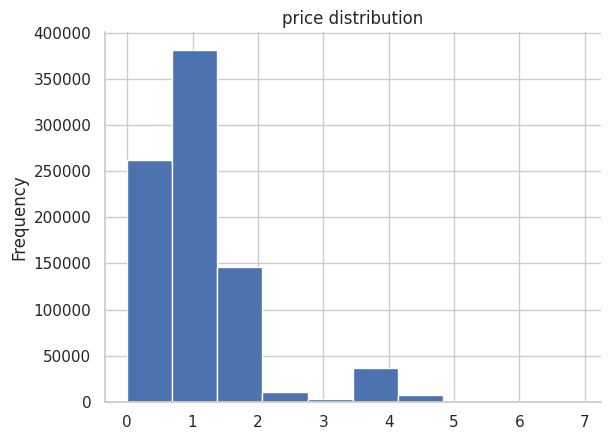

In [ ]:
from matplotlib import pyplot as plt
df_features['price'].plot(kind='hist', title='price distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)

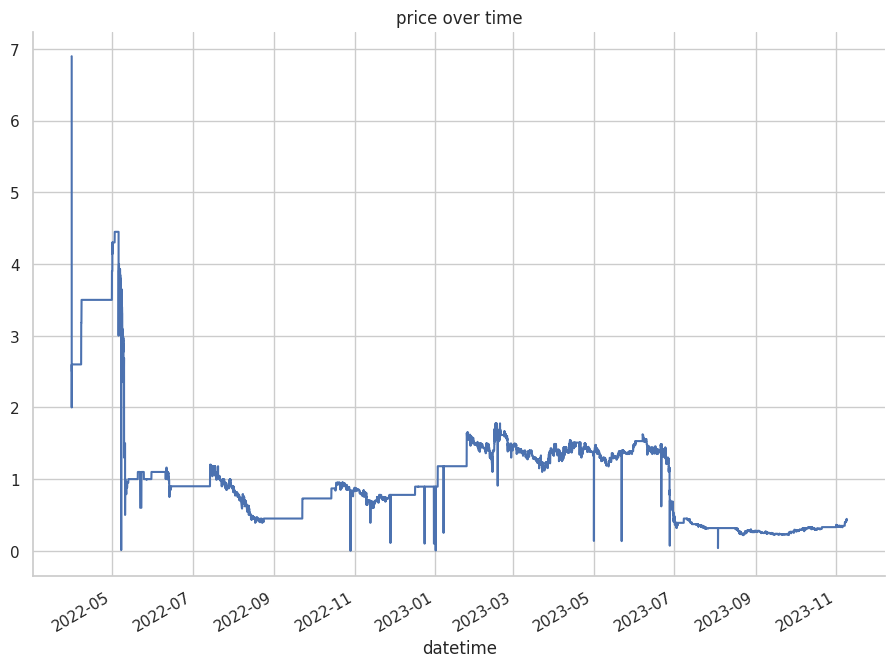

In [ ]:
df_features['price'].plot(kind='line', figsize=(11, 8), title='price over time')
plt.gca().spines[['top', 'right']].set_visible(False)

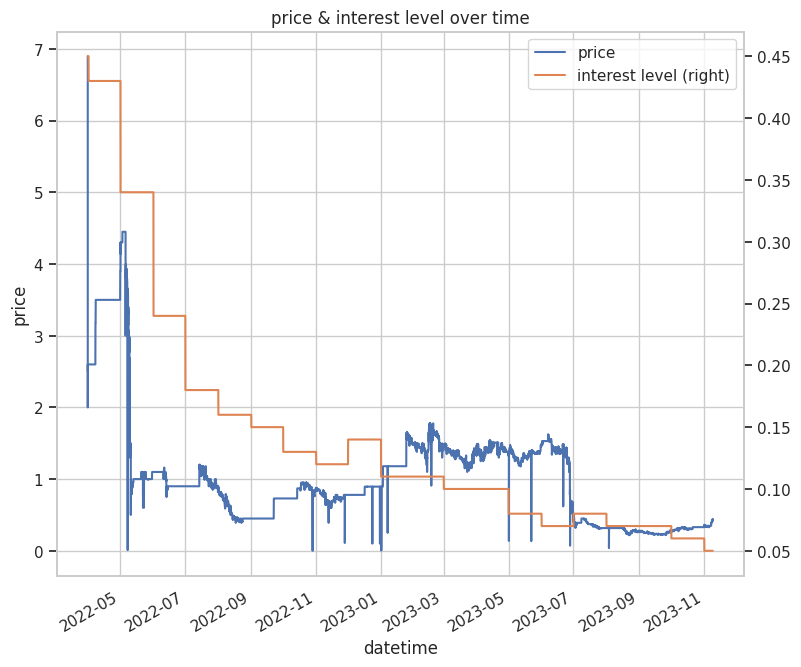

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
fig.subplots_adjust(right=0.75)
df_features['price'].plot(label="price", ax=ax, legend=True)
df_features['google_searches_nft_scaled'].plot(label="interest level", ax=ax, legend=True, secondary_y=True)

ax.set_xlabel("datetime")
ax.set_ylabel("price")
plt.title("price & interest level over time")
plt.show()

lower interest -> lower number of listings & lower price

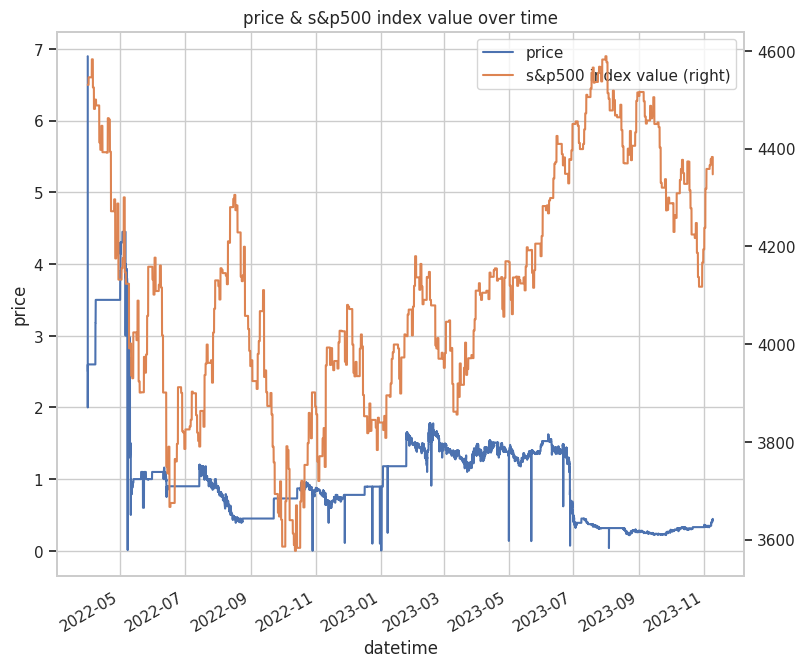

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
fig.subplots_adjust(right=0.75)
df_features['price'].plot(label="price", ax=ax, legend=True)
df_features['sp500_value'].plot(label="s&p500 index value", ax=ax, legend=True, secondary_y=True)

ax.set_xlabel("datetime")
ax.set_ylabel("price")
plt.title("price & s&p500 index value over time")
plt.show()

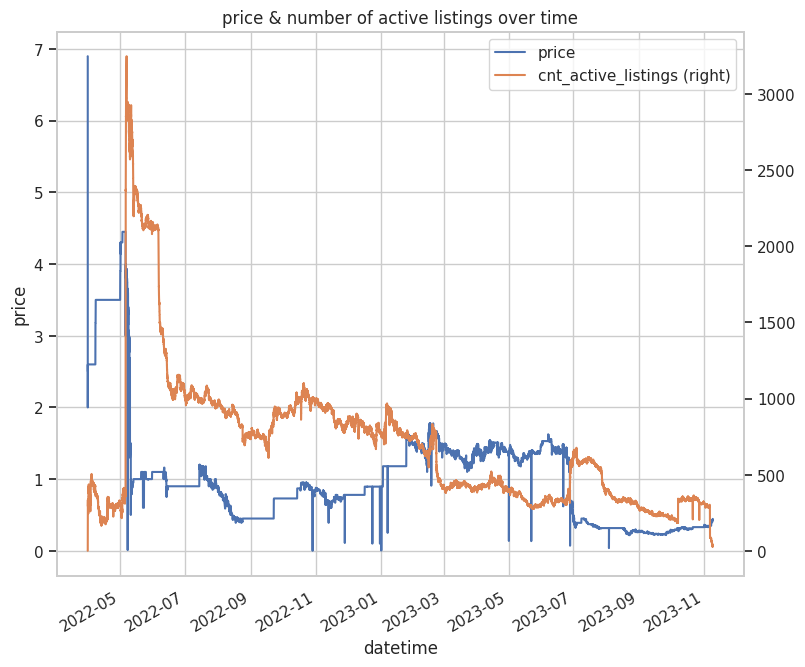

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
fig.subplots_adjust(right=0.75)
df_features['price'].plot(label="price", ax=ax, legend=True)
df_features['cnt_active_listings'].plot(label="cnt_active_listings", ax=ax, legend=True, secondary_y=True)

ax.set_xlabel("datetime")
ax.set_ylabel("price")
plt.title("price & number of active listings over time")
plt.show()

end of may 2022-massive increase of number of active listings -> drop in price

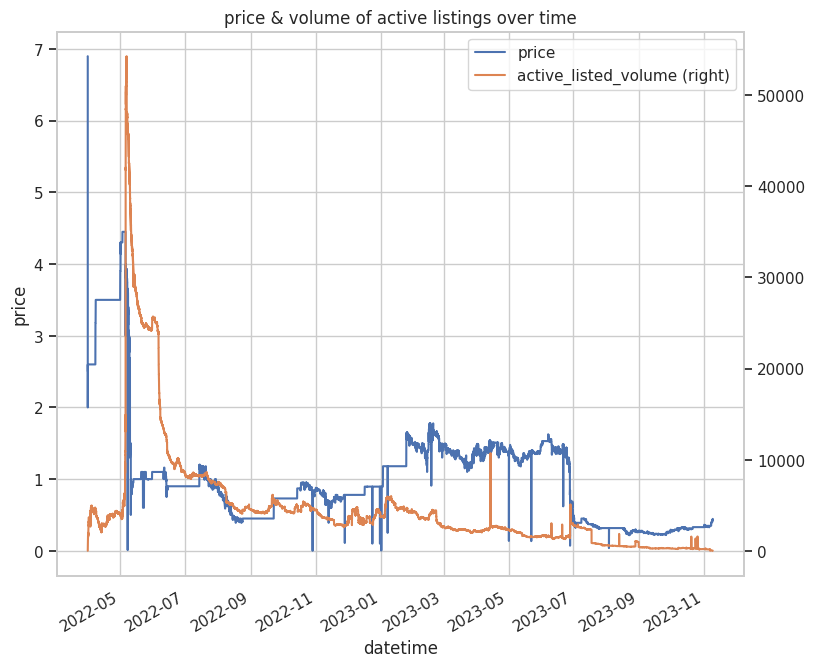

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
fig.subplots_adjust(right=0.75)
df_features['price'].plot(label="price", ax=ax, legend=True)
df_features['active_listed_volume'].plot(label="active_listed_volume", ax=ax, legend=True, secondary_y=True)

ax.set_xlabel("datetime")
ax.set_ylabel("price")
plt.title("price & volume of active listings over time")
plt.show()

# Correlation between features

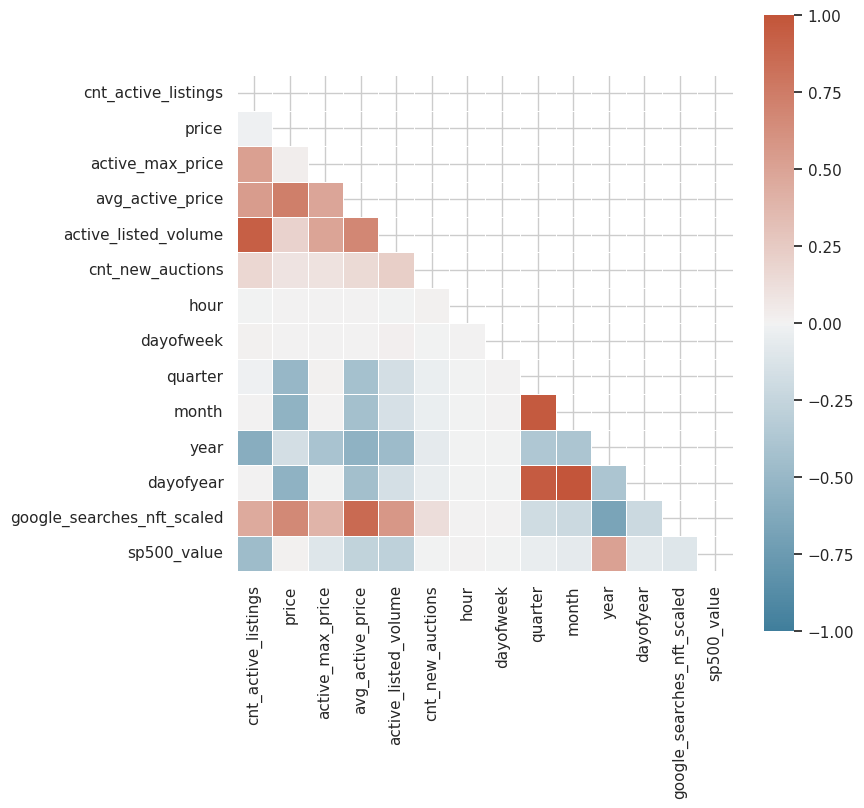

In [ ]:
import seaborn as sns
correlation_matrix = df_features.corr()

# Set up the matplotlib figure
fig,ax = plt.subplots(figsize=(8, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Define a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, ax=ax)
plt.show()

In [ ]:
import gc
# add time index
tmp = df_features.reset_index().drop_duplicates()
data = (tmp.merge((tmp[['datetime']].drop_duplicates(ignore_index=True)
.rename_axis('time_idx')).reset_index(), on = ['datetime'])).set_index('datetime').copy()

del tmp
gc.collect()

6902

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 846374 entries, 2022-03-31 05:47:00 to 2023-11-09 00:00:00
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   cnt_active_listings         846374 non-null  Int64  
 1   price                       846374 non-null  float16
 2   active_max_price            846374 non-null  float64
 3   avg_active_price            846374 non-null  float64
 4   active_listed_volume        846374 non-null  int64  
 5   cnt_new_auctions            846374 non-null  Int64  
 6   hour                        846374 non-null  int64  
 7   dayofweek                   846374 non-null  int64  
 8   quarter                     846374 non-null  int64  
 9   month                       846374 non-null  int64  
 10  year                        846374 non-null  int64  
 11  dayofyear                   846374 non-null  int64  
 12  google_searches_nft_scaled  846374 non

# Creating time series dataset

In [ ]:
#acf plot as a tool for determining first max_encoder_length hyperparameter value
#from statsmodels.graphics.tsaplots import plot_acf
# Plot the ACF
#plot_acf(data['price'], lags=[50, 120, 240, 360, 600], alpha=.05)
#plt.title('Autocorrelation Function (ACF) Plot')
#plt.xlabel('Lag')
#plt.ylabel('Autocorrelation')
#plt.show()

In [ ]:
max_prediction_length = 30 #predicting 30 minutes ahead
max_encoder_length = 30 #predicting using past 30 minutes
training_cutoff = data["time_idx"].max() - max_prediction_length #last 30 minutes for validation

### Data modification for TimeSeriesDataSet creation

In [ ]:
#Only 1 group
data['group'] = 'beanz'

for col in ['hour','dayofweek','quarter','month','year','dayofyear']:
  data[col] = data[col].astype(str).astype('category')

data=data.astype({
    "active_listed_volume":np.int16,
    "avg_active_price":np.float16,
    "active_max_price":np.float16,
    "price":np.float16,
    "google_searches_nft_scaled":np.float16,
    "sp500_value":np.float16,
    "cnt_new_auctions":np.int16,
    "cnt_active_listings":np.int16
})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 846374 entries, 2022-03-31 05:47:00 to 2023-11-09 00:00:00
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   cnt_active_listings         846374 non-null  int16   
 1   price                       846374 non-null  float16 
 2   active_max_price            846374 non-null  float16 
 3   avg_active_price            846374 non-null  float16 
 4   active_listed_volume        846374 non-null  int16   
 5   cnt_new_auctions            846374 non-null  int16   
 6   hour                        846374 non-null  category
 7   dayofweek                   846374 non-null  category
 8   quarter                     846374 non-null  category
 9   month                       846374 non-null  category
 10  year                        846374 non-null  category
 11  dayofyear                   846374 non-null  category
 12  google_searches_nft_scal

In [ ]:
data=data.reset_index()

In [ ]:
np.any(np.isnan(data.drop(columns=['hour','dayofweek','quarter','month','year','dayofyear','group'])))

False

In [ ]:
np.all(np.isfinite(data.drop(columns=['hour','dayofweek','quarter','month','year','dayofyear','group'])))

True

In [ ]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals = ['hour','dayofweek','quarter','month','year','dayofyear'],
    time_varying_known_reals = ['time_idx'],
    time_varying_unknown_reals  = ['sp500_value', 'google_searches_nft_scaled', 'cnt_active_listings', 'price','active_max_price','avg_active_price','active_listed_volume','cnt_new_auctions'],
    allow_missing_timesteps = False,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    target_normalizer = GroupNormalizer(
        groups=["group"], transformation="softplus"
    ),
    target='price',
    group_ids=['group'],
    static_categoricals=['group']
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [ ]:
# create dataloaders for model
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

# Training

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor="val_loss")
lr_logger = LearningRateMonitor()  # log the learning rate
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min") #stop when training no longer effective

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=10,
    enable_model_summary=True,
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, lr_logger, early_stop_callback]
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.01,
    lstm_layers=2,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="Ranger",
    reduce_on_plateau_patience=10,  # reduce learning rate if no improvement in validation loss after x epochs
)

wandb_logger.watch(tft)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 15.6k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K 
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initia

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]